<center> </center>

<center><font size=5 face="Helvetica" color=#EE4B2B><b>
Pytorch Tutorial: Datasets & Dataloaders
</b></font></center>

<center><font face="Helvetica" size=3><b>Ang Chen</b></font></center>
<center><font face="Helvetica" size=3>July, 2024</font></center>

***

Code for processing data samples can get messy and hard to maintain;
we ideally want our dataset code to be decoupled from our model training code for better readability and modularity.
Pytorch provides two data promitives: $\texttt{torch.utils.data.DataLoader}$ and $\texttt{torch.utils.data.Dataset}$ that 
allow you to use pre-loaded datasets as well as your own data.
$\texttt{Dataset}$ stores the samples and their corresponding labels, and $\texttt{DataLoader}$ wraps an iterable around the $\texttt{Dataset}$ 
to enable easy access to the samples.

Pytorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass $\texttt{torch.utils.data.Dataset}$ and implement functions specific to the particular data.
They can be used to prototype and benchmark your model.


# Loading a Dataset

Here is an example of how to load the Fashion-MNIST dataset from TorchVision.
Fashion-MNIST is a dataset of Zalando's article images consisting of 60,000 training examples and 10,000 test examples.
Each example is a 28$\times$28 grayscale image, associated with a label from one of 10 classes.

We load the FashionMNIST Dataset with the following parameters:
 * $\texttt{root}$ is the path where the train/test data is stored,
 * $\texttt{train}$ sppecifies training or test dataset,
 * $\texttt{download=True}$ downloads the data from the internet if it's not avaialable at $\texttt{root}$.
 * $\texttt{transform}$ and $\texttt{target\_transform}$ specify the feature and label transformations.
 

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [8]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Iterating and Visualizing the Dataset

We can index $\texttt{Datasets}$ manually like a list: $\texttt{training\_data[index]}$. 
We use $\texttt{matplotlib}$ to visualize some samples in our training data.

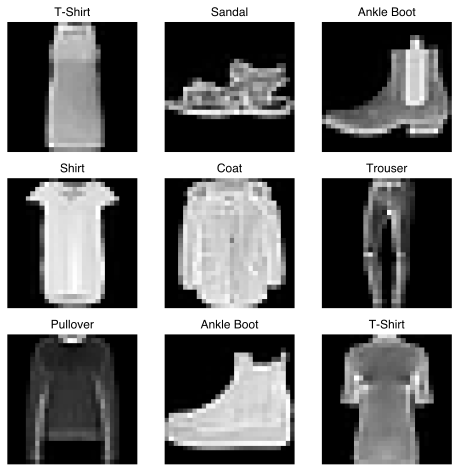

In [36]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Creating a Custom Dataset for your files

A custom Dataset class must implement three functions:  $\texttt{\_\_init\_\_}$, $\texttt{\_\_len\_\_}$, and $\texttt{\_\_getitem\_\_}$.
Take a look at this implementation; the FashionMNIST images are stored in a directory $\texttt{img\_dir}$,